In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras as kr
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Data Engineering and preprocessing

Make a functions for creating the dataframe with images and information there

In [19]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    return df

Find a path to our images

In [20]:
train = Path('train')
test = Path('test')
val = Path('validation')

train_filepaths = list(train.glob(r'**/*.jpg'))
test_filepaths = list(test.glob(r'**/*.jpg'))
val_filepaths = list(test.glob(r'**/*.jpg'))

Make a dataframes from the images and information we have

In [21]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

See the result

In [22]:
train_df.head(5)

,Filepath,Label
0,train/chilli pepper/Image_14.jpg,chilli pepper
1,train/mango/Image_28.jpg,mango
2,train/ginger/Image_61.jpg,ginger
3,train/carrot/Image_72.jpg,carrot
4,train/eggplant/Image_65.jpg,eggplant


In [23]:
test_df.head(5)

,Filepath,Label
0,test/sweetcorn/Image_8.jpg,sweetcorn
1,test/cabbage/Image_7.jpg,cabbage
2,test/apple/Image_4.jpg,apple
3,test/cucumber/Image_6.jpg,cucumber
4,test/apple/Image_1.jpg,apple


In [24]:
val_df.head(5)

,Filepath,Label
0,test/orange/Image_7.jpg,orange
1,test/bell pepper/Image_6.jpg,bell pepper
2,test/pear/Image_2.jpg,pear
3,test/sweetcorn/Image_10.jpg,sweetcorn
4,test/bell pepper/Image_5.jpg,bell pepper


In [25]:
train_df.describe(include="all")

,Filepath,Label
count,2780,2780
unique,2780,36
top,train/chilli pepper/Image_14.jpg,soy beans
freq,1,92


Let's see all images by unigue labels(show them)

In [26]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

In [27]:
df_unique.to_csv('../CV_task_with_flusk/unique.csv')

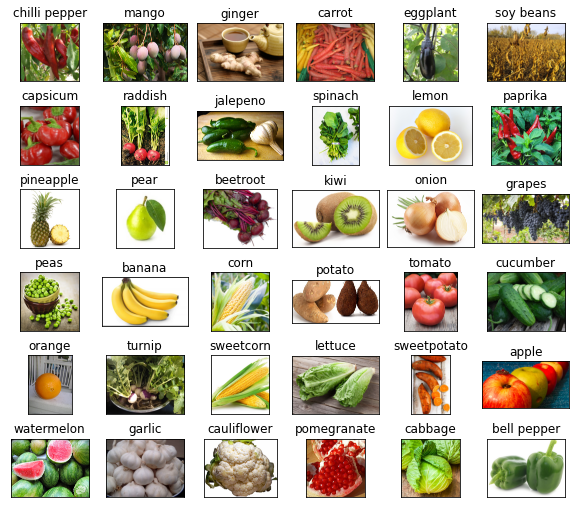

In [28]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Load the Images with a generator and Data Augmentation

First of all, make new function for generator with a different preprocessing functions

In [29]:
def set_generator(function):
    generator = ImageDataGenerator(preprocessing_function = function)
    train_images = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    val_images = generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_images = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_images, val_images, test_images

# Train the model

Secondly, train the model

In [30]:
def train_model_params(model_train, activation,tr, val):
    pretrained_model = model_train
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = kr.layers.Dense(128, activation= activation)(pretrained_model.output)
    x = kr.layers.Dense(128, activation= activation)(x)

    outputs = kr.layers.Dense(36, activation='softmax')(x)

    model = kr.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(tr, validation_data=val, batch_size = 32, epochs=5)

    return history, model

And make the predictions

In [46]:
def make_predictions(model, tr, ts):
    # Predict the label of the test_images
    pred = model.predict(ts)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (tr.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = [labels[k] for k in ts.classes]

    # Count Accuracy
    acc = accuracy_score(y_test, pred)
    print(f'Accuracy on the test set: {100*acc:.2f}%')

    # Show images
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
    plt.tight_layout()
    plt.show()

For the first example I decided to use MobileNetV2 arhitecture for test

In [32]:
train_images, val_images, test_images = set_generator(kr.applications.mobilenet_v2.preprocess_input)
param = kr.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'
)
hist, mod = train_model_params(param, 'relu', train_images, val_images)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


2022-02-22 22:03:15.912954: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
87/87 [==============================] - 354s 4s/step - loss: 1.7404 - accuracy: 0.5536 - val_loss: 0.4833 - val_accuracy: 0.8533
Epoch 2/5
87/87 [==============================] - 312s 4s/step - loss: 0.5645 - accuracy: 0.8209 - val_loss: 0.3054 - val_accuracy: 0.9042
Epoch 3/5
87/87 [==============================] - 289s 3s/step - loss: 0.3409 - accuracy: 0.8885 - val_loss: 0.2290 - val_accuracy: 0.9341
Epoch 4/5
87/87 [==============================] - 293s 3s/step - loss: 0.2089 - accuracy: 0.9327 - val_loss: 0.1922 - val_accuracy: 0.9551
Epoch 5/5
87/87 [==============================] - 287s 3s/step - loss: 0.1482 - accuracy: 0.9540 - val_loss: 0.2320 - val_accuracy: 0.9431


In [33]:
make_predictions(mod, train_images, test_images)

Accuracy on the test set: 94.31%


<Figure size 432x288 with 0 Axes>

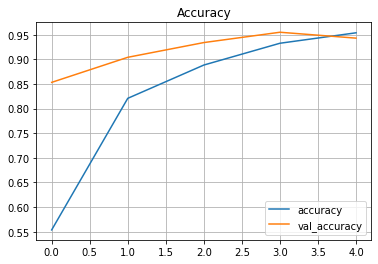

In [34]:
pd.DataFrame(hist.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.grid()
plt.show()

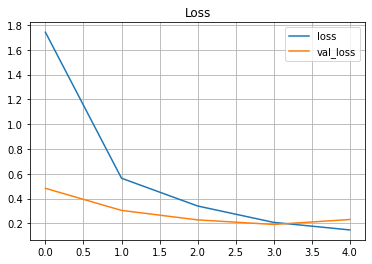

In [35]:
pd.DataFrame(hist.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.grid()
plt.show()

# ResNet50V2

In [36]:
train_images, val_images, test_images = set_generator(kr.applications.resnet_v2.preprocess_input)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [37]:
param = kr.applications.ResNet50V2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'
)
hist, mod = train_model_params(param, 'relu', train_images, val_images)

Epoch 1/5
87/87 [==============================] - 372s 4s/step - loss: 1.6900 - accuracy: 0.5478 - val_loss: 0.5159 - val_accuracy: 0.8234
Epoch 2/5
87/87 [==============================] - 404s 5s/step - loss: 0.6070 - accuracy: 0.8162 - val_loss: 0.3136 - val_accuracy: 0.9162
Epoch 3/5
87/87 [==============================] - 398s 5s/step - loss: 0.3711 - accuracy: 0.8781 - val_loss: 0.2266 - val_accuracy: 0.9461
Epoch 4/5
87/87 [==============================] - 400s 5s/step - loss: 0.2125 - accuracy: 0.9381 - val_loss: 0.2456 - val_accuracy: 0.9461
Epoch 5/5
87/87 [==============================] - 455s 5s/step - loss: 0.1711 - accuracy: 0.9489 - val_loss: 0.1949 - val_accuracy: 0.9611


In [38]:
make_predictions(mod, train_images, test_images)

Accuracy on the test set: 96.11%


<Figure size 432x288 with 0 Axes>

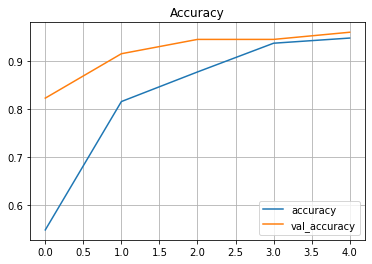

In [39]:
pd.DataFrame(hist.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.grid()
plt.show()

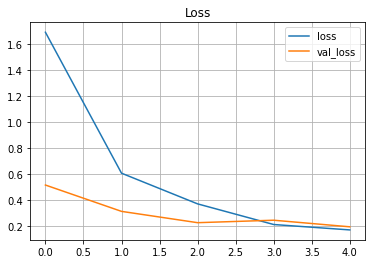

In [40]:
pd.DataFrame(hist.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.grid()
plt.show()

# Save the model

In [43]:
mod.save('../CV_task_with_flusk/model.h5')

In [44]:
df_unique.Label.to_list()

['chilli pepper',
 'mango',
 'ginger',
 'carrot',
 'eggplant',
 'soy beans',
 'capsicum',
 'raddish',
 'jalepeno',
 'spinach',
 'lemon',
 'paprika',
 'pineapple',
 'pear',
 'beetroot',
 'kiwi',
 'onion',
 'grapes',
 'peas',
 'banana',
 'corn',
 'potato',
 'tomato',
 'cucumber',
 'orange',
 'turnip',
 'sweetcorn',
 'lettuce',
 'sweetpotato',
 'apple',
 'watermelon',
 'garlic',
 'cauliflower',
 'pomegranate',
 'cabbage',
 'bell pepper']

# TSNE Visualization

In [ ]:
# tsne = TSNE(n_components=2).fit_transform(features)